In [1]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import IPython
import torch as ch
from torch import Tensor
from torch.distributions import Uniform, Gumbel
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LogisticRegression as LogisticRegression_
import config

from delphi.stats.logistic_regression import LogisticRegression
from delphi import oracle
from delphi import train 
import delphi.utils.constants as consts
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# Helpers

In [2]:
# EXP_NAME = 'TruncatedLogisticRegressionWeightDecay'
# EXP_NAME = 'TruncatedLogisticRegression1e-1'
EXP_NAME = 'Test'
STORE_PATH = '/home/gridsan/stefanou/LogisticRegression/' + EXP_NAME
STORE_TABLE_NAME = 'results'

## Default Experiment Parameters

In [7]:
# procedure hyperparameters
args = Parameters({ 
    'workers': 8, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 1000,
    'samples': 10000, 
    'in_features': 2, 
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-2,
    'shuffle': False, 
    'tol': 1e-2,
    'eps': 1e-5,
    'score': True,
    'custom_lr_multiplier': consts.COSINE,
    'var': True,
    'momentum': 0.0, 
    'weight_decay': 0.0, 
    'lower': -1, 
    'upper': 1,
    'multi': 'multinomial',
    'out_features': 2, 
    'alpha_thresh': .5, 
    'steps': 10000, 
    'log_iters': 1,
    'accuracy': True,
})

if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
    print("using cuda...")
else: 
    args.__setattr__('device', 'cpu')

using cuda...


In [8]:
def gen_data(): 
    """
    Generate dataset for truncated multinomial logistic 
    regression model. Returns ground_truth and train, validation, and test loaders.
    """
    # distributions
    gumbel = Gumbel(0, 1)
    U = Uniform(args.lower, args.upper) # distribution to generate ground-truth parameters
    U_ = Uniform(-5, 5) # distribution to generate samples
    
    # no grad required for dataset
    with ch.no_grad():
        # generate synthetic data until survival probability of more than 40%
        alpha = None
        while alpha is None or alpha < args.ALPHA_THRESH:
            # generate ground-truth from uniform distribution
            ground_truth = ch.nn.Linear(in_features=args.in_features, out_features=args.out_features, bias=args.bias)
            ground_truth.weight = ch.nn.Parameter(U.sample(ch.Size([args.out_features, args.IN_FEATURES])))
            if ground_truth.bias is not None: 
                ground_truth.bias = ch.nn.Parameter(U.sample(ch.Size([args.out_features,])))
            # independent variable 
            X = U_.sample(ch.Size([args.samples, args.in_features]))
            # determine base model logits 
            z = ground_truth(X)
            # add noise to the logits
            noised = z + gumbel.sample(z.size())
            # apply softmax to unnormalized likelihoods
            y = ch.argmax(noised, dim=1)

            # TRUNCATE
            trunc = args.phi(z)
            indices = ch.all(trunc.bool(), dim=1).float().nonzero(as_tuple=False).flatten()
            x_trunc, y_trunc = X[indices].cpu(), y[indices].cpu()
            alpha = x_trunc.size(0) / X.size(0)
            
        print("alpha: {}".format(alpha))

        # all synthetic data 
        # split ds into training and validation data sets - 80% training, 20% validation
        train_length = int(len(x_trunc)*.8)
        val_length = len(x_trunc) - train_length
        train_x, train_y = x_trunc[:train_length], y_trunc[:train_length]
        val_x, val_y = x_trunc[train_length:], y_trunc[train_length:]

        # test dataset
        x_test = X[~indices].cpu()
        y_test = y[~indices].cpu()
            
    return ground_truth, ((train_x, train_y), (val_x, val_y)), (x_test, y_test), alpha

In [9]:
class epoch_hook: 
    """
    End epoch hook for training procedure. 
    """
    def __init__(self, store, table_name=None, ground_truth=None): 
        # model ground truth
        self.gt_params = None
        if ground_truth is not None: 
            self.gt_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(1)
        self.store = store
        
        # check for different table name
        self.table_name = table_name
        if not table_name: 
            self.table_name = 'ground_truth_table'
        self.store.add_table(self.table_name, { 
            'cos_sim': float, 
            'l2': float,
            'epoch': int,
        })
        
    # set ground_truth for exp
    def set_ground_truth(self, ground_truth): 
        self.gt_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(1)

    def __call__(self, model, epoch): 
        # current model parameters
        trunc_params = ch.cat([model.weight.flatten(), model.bias]).unsqueeze(1).cpu()
        # cosine similarity and l2 distance
        cos_sim = float(ch.nn.functional.cosine_similarity(self.gt_params, trunc_params, dim=0))
        l2_dist = float(ch.nn.MSELoss()(self.gt_params, trunc_params))

        ground_truth_info = { 
            'epoch': epoch + 1, 
            'cos_sim': cos_sim, 
            'l2': l2_dist,
        }

        self.store[self.table_name].append_row(ground_truth_info)

# Experiment

In [10]:
# establish oracle 
args.__setattr__('phi', oracle.Identity())

# create store
store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'delphi_cos': float,
    'mle_cos': float,
    'alpha': float, 
})

# generate data
ground_truth, data, test_data, alpha = gen_data()

# set initial manual seed, so that procedures start from same point
ch.manual_seed(0)

# truncated logistic regression
log_reg = LogisticRegression(args.phi, alpha, args, device=args.device, multi_class=args.multi, store=store, table='delphi_logs')
results = log_reg.fit(data[0][0], data[0][1])
w, w0 = results.weight.detach().cpu(), results.bias.detach().cpu()

# set initial manual seed, so that procedures start from same point
ch.manual_seed(0)

# new classifier models at the beginning of each trial
standard_log_reg = ch.nn.Linear(in_features=args.in_features, out_features=args.out_features, bias=args.bias)
train_loader = DataLoader(TensorDataset(data[0][0], data[0][1]), num_workers=args.workers, batch_size=args.batch_size)
val_loader = DataLoader(TensorDataset(data[1][0], data[1][1]), num_workers=args.workers, batch_size=args.batch_size)
# naive ce loss
args.__setattr__('custom_criterion', ch.nn.CrossEntropyLoss()) # default ce loss
train.train_model(args, standard_log_reg, (train_loader, val_loader), store=store, 
            table='standard_logs')

# parameter estimates 
real_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(0).cpu()
mle_params = ch.cat([standard_log_reg.weight.flatten(), standard_log_reg.bias]).unsqueeze(0).cpu()
delphi_params = ch.cat([w.flatten(), w0]).unsqueeze(0).cpu()

store[STORE_TABLE_NAME].append_row({ 
    'delphi_cos': F.cosine_similarity(delphi_params, Tensor(real_params)),
    'mle_cos': F.cosine_similarity(mle_params, real_params),
    'alpha': float(args.alpha),
})

IPython.display.clear_output(wait=False)
1
# close current store
store.close()

# Results

In [11]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
standard_logs = reader.df('standard_logs')
delphi_logs = reader.df('delphi_logs')
reader.close() # close reader
results.head()

100%|██████████| 1/1 [00:00<00:00, 64.28it/s]


,delphi_cos,mle_cos,alpha,exp_id
0,0.456792,0.454044,1.0,641e30e2-241a-486c-bb64-3d10e9a2dd8a


# Training Curves

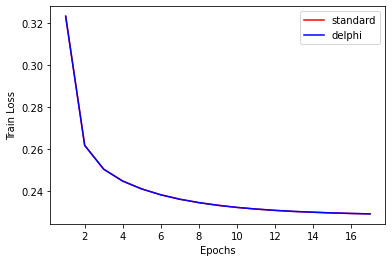

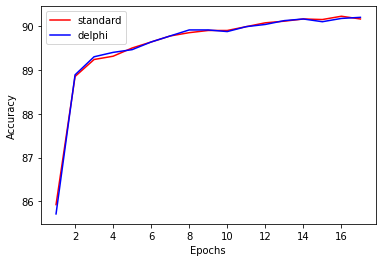

In [12]:
# loss curve 
sns.lineplot(data=standard_logs, x='epoch', y='train_loss', label='standard', color='red')
ax = sns.lineplot(data=delphi_logs, x='epoch', y='train_loss', label='delphi', color='blue')
ax.set(xlabel='Epochs', ylabel='Train Loss')
plt.show()

# acc curve 
sns.lineplot(data=standard_logs, x='epoch', y='train_prec1', label='standard', color='red')
ax = sns.lineplot(data=delphi_logs, x='epoch', y='train_prec1', label='delphi', color='blue')
ax.set(xlabel='Epochs', ylabel='Accuracy')
plt.show()

In [13]:
class Interval:
    """
    Interval truncation
    """
    # tensor inputs for vector interval truncation
    def __init__(self, lower, upper):
        self.bounds = Bounds(lower, upper)

    def __call__(self, x):
        # check sample device
        if x.is_cuda:
            return ((self.bounds.lower.cuda() < x).prod(-1) * (x < self.bounds.upper.cuda()).prod(-1))
        return ((self.bounds.lower < x).prod(-1) * (x < self.bounds.upper).prod(-1))

In [14]:
test_phi = Interval(ch.full(ch.Size([2,]), -1), ch.full(ch.Size([2,]), 1))

NameError: name 'Bounds' is not defined